In [1]:
import os, warnings, sys, yaml
from stream2segment.process.db import get_session
from stream2segment.io.db.models import Station, Segment, concat, Channel
from stream2segment.io.utils import loads_inv
# warnings.simplefilter('always')
_fle = os.path.abspath(os.path.join('.', 'jnconfig.yaml'))
assert os.path.isfile(_fle)
with open(_fle, "r") as _:
    jnconfig = yaml.safe_load(_)

dbpath_old = jnconfig['dbpath_old']
dbpath_new = jnconfig['dbpath_new']

In [2]:
def station_key(station):
    return station.network + '.' + station.station + '.' + station.start_time.isoformat()

def printred(string):
    print("\x1b[31m%s\x1b[0m" % string)

In [3]:
from stream2segment.process.math.traces import ampratio, bandpass, cumsumsq,\
    timeswhere, fft, maxabs, utcdatetime, ampspec, powspec, timeof
preprocess_config = {
  'remove_response_water_level': 60,
  'remove_response_output': 'ACC',
  'bandpass_freq_max': 30,  # the max frequency, in Hz:
  'bandpass_max_nyquist_ratio': 0.9,
  'bandpass_corners': 2
}
def bandpass_remresp(segment, inventory=None):
    """Applies a pre-process on the given segment waveform by
    filtering the signal and removing the instrumental response.
    DOES modify the segment stream in-place (see below)

    The filter algorithm has the following steps:
    1. Sets the max frequency to 0.9 of the Nyquist frequency (sampling rate /2)
    (slightly less than Nyquist seems to avoid artifacts)
    2. Offset removal (subtract the mean from the signal)
    3. Tapering
    . Pad data with zeros at the END in order to accommodate the filter transient
nf['bandpass_freq_max']
    5. Apply bandpass filter, where the lower frequency is set according to the magnitude
    6. Remove padded elements
    7. Remove the instrumental response

    IMPORTANT NOTES:
    - Being decorated with '@gui.preprocess', this function:
      * returns the *base* stream used by all plots whenever the relative check-box is on
      * must return either a Trace or Stream object

    - In this implementation THIS FUNCTION DOES MODIFY `segment.stream()` IN-PLACE: from within
      `main`, further calls to `segment.stream()` will return the stream returned by this function.
      However, In any case, you can use `segment.stream().copy()` before this call to keep the
      old "raw" stream

    :return: a Trace object.
    """
    stream = segment.stream().copy()
    trace = stream[0]

    if inventory is None:
        inventory = segment.inventory()

    # define some parameters:
    evt = segment.event
    conf = preprocess_config
    # note: bandpass here below copied the trace! important!
    trace = bandpass(trace, mag2freq(evt.magnitude), freq_max=conf['bandpass_freq_max'],
                     max_nyquist_ratio=conf['bandpass_max_nyquist_ratio'],
                     corners=conf['bandpass_corners'], copy=False)
    trace.remove_response(inventory=inventory, output=conf['remove_response_output'],
                          water_level=conf['remove_response_water_level'])
    return trace

def mag2freq(magnitude):
    if magnitude <= 4.:
        freq_min = 0.5
    elif magnitude <= 5.0:
        freq_min = 0.4
    elif magnitude <= 6.0:
        freq_min = 0.2
    elif magnitude <= 6.5:
        freq_min = 0.1
    else:
        freq_min = 0.05
    return freq_min


In [25]:
def get_cha_obj(segment):
    for n, net in enumerate(segment.inventory()):
        if net.code == segment.station.network:
            for s, sta in enumerate(net):
                if sta.code == segment.station.station:
                    for c, cha in enumerate(sta):
                        if cha.code == segment.channel.channel:
                            return cha
    return None

def get_other_channels(segment):
    '''Yields channels objects within the given inventory'''
    inventory = segment.inventory()
    is_accel = is_accelerometer(segment)
    for n, net in enumerate(inventory):
        for s, sta in enumerate(net):
            for c, cha in enumerate(sta):
                if _is_accelerometer(cha.code) != is_accel:
                    print('channel code: %s, other channel code: %s' % (segment.channel.channel, cha.code))
                    yield cha

def is_accelerometer(segment):
    # we might use channel code but we want to call _is_accelerometer:
    return _is_accelerometer(segment.channel.channel)

def _is_accelerometer(channel_code):
    return channel_code[1:2].lower() in ('n', 'l', 'g')

def replaceinv_stream(segment):
    traces = [bandpass_remresp(segment)]
    other_channels = list(get_other_channels(segment))
    print(len(other_channels))
    cha = get_cha_obj(segment)
    resp_tmp = cha.response
    for other_cha in other_channels:
        cha.response = other_cha.response
        traces.append(bandpass_remresp(segment))
    cha.response = resp_tmp
    return Stream(traces)
    

In [26]:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
from sqlalchemy import func
import random

sess = get_session(dbpath_new)

# STATION = 'CH.GRIMS'
# STATION = 'FR.PYLO'
# STATION = 'SK.MODS'
# STATION = 'SK.ZST'

# NOT WORKING (not in both databses, or no channels etc):
# SK_SRO_EH, SL_KNDS_HH, SL_JAVS_HH IV_SGG_HN
# CQ_PARA_HH CQ_ATHA_HH CQ_TROD_HH CQ_NATA_HH CQ_SUNI_HH CQ_MVOU_HH CQ_ASGA_HH CQ_ALEF_HH CQ_AKMS_HH


#   " "" "" "" "

numsegs = 3
print('PICKING %d RANDOM SEGMENTS (might take a while) from new dbase' % numsegs)

segments = []  # list of (segment id, Stream, Inventory) data
inventories = []
rr_streams = []

stations, networks = set(), set()
try:
    station = sess.query(Station).join(Station.channels).filter(
                (Station.has_inventory==True) & # Station.segments.any(Segment.has_data) &
                (Segment.has_data==True) & # Station.segments.any(Segment.has_data) &
                (Station.channels.any(Channel.instrument_code.in_(["N", "L" ,"G"]))) &
                (Station.channels.any(~Channel.instrument_code.in_(["N", "L" ,"G"])))
            ).limit(numsegs).limit(1).first()
    print(station)

    segments = sess.query(Segment).join(Segment.station).filter(
                (Station.id==station.id) & # Station.segments.any(Segment.has_data) &
                (Segment.has_data==True)
            ).limit(numsegs).all()
#     for seg in segs:
#         trace_ = None
#         try:
#             stream_ = seg.stream()
#             inv_ = sta.inventory()  # assure it is possible to load the inventory
#             trace_ = None if len(stream_) != 1 else stream_[0]
#         except:
#             raise
#         if trace_ is not None:
#             print('saving segment %d of %d' % (len(segments)+1, numsegs))
#             segments.append(seg)
#             inventories.append(seg.inventory())

    rr_streams = []
    for s in segments:
        rr_streams.append(replaceinv_stream(s))
finally:
    sess.close()



print('Fetched %d segments with data from %d different stations' % (len(rr_streams), len(rr_streams)))
print('%d segments with "wrong" inventories' % len(rr_streams))

PICKING 3 RANDOM SEGMENTS (might take a while) from new dbase
Station
 columns (11 of 11 loaded):
  id: 9802
  datacenter_id: 1
  network: GE
  station: IMMV
  latitude: 35.4606
  longitude: 23.9811
  elevation: 230.0
  site_name: None
  start_time: 2010-07-14T00:00:00
  end_time: None
  inventory_xml: b'\x1f\x8b\x08\x00\x94\x18\xad\\\x02\xff\xec\xbdmoU\xc7\xb25\xfaW\x10\xf7\xcb>\xd2\xf5tWUW ... (showing first 30 characters only)'
 relationships (0 of 3 loaded):
  datacenter
  channels
  segments
channel code: HHE, other channel code: HNZ
channel code: HHE, other channel code: HNE
channel code: HHE, other channel code: HNN
3
channel code: HHN, other channel code: HNZ
channel code: HHN, other channel code: HNE
channel code: HHN, other channel code: HNN
3
channel code: HHZ, other channel code: HNZ
channel code: HHZ, other channel code: HNE
channel code: HHZ, other channel code: HNN
3
Fetched 3 segments with data from 3 different stations
3 segments with "wrong" inventories



Segment #1. Blue trace is normal one, others are with "fake" inventories


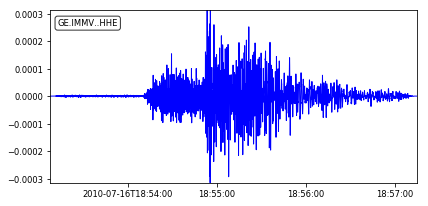

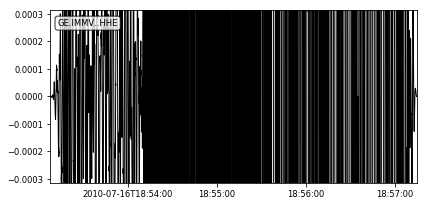

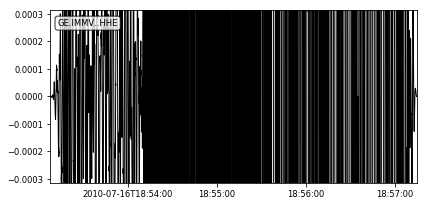

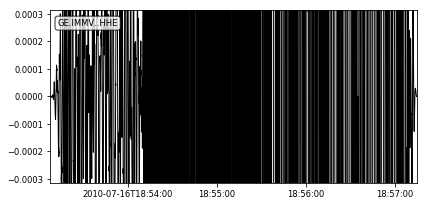


Segment #2. Blue trace is normal one, others are with "fake" inventories


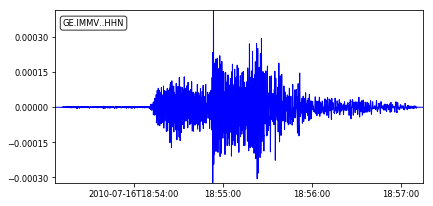

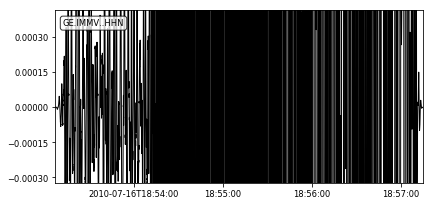

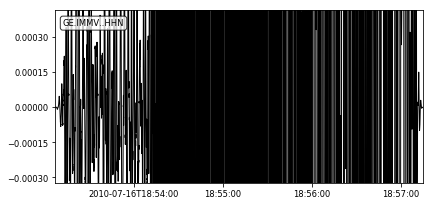

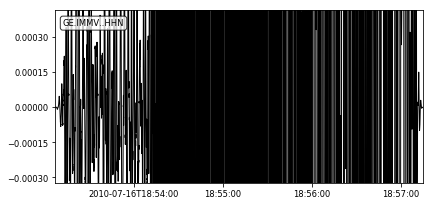


Segment #3. Blue trace is normal one, others are with "fake" inventories


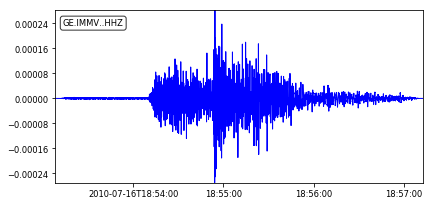

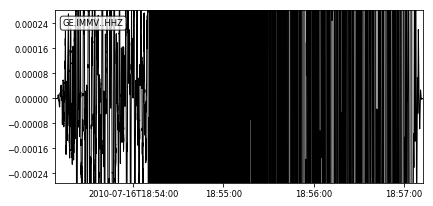

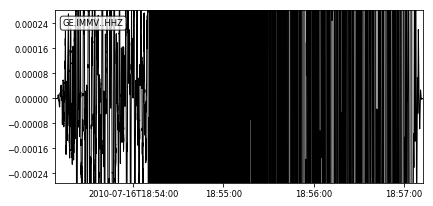

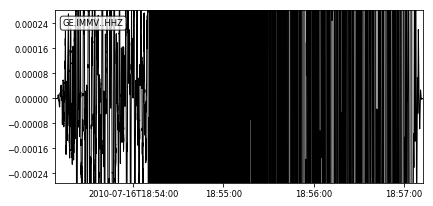

In [27]:
# let's try with one and plot it, you will see they are identical just SCALED:
from obspy import Trace, Stream, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for kkk, stream in enumerate(rr_streams):
    figs = []
    min_, max_ = None, None
    color = 'blue'
    print('\nSegment #%d. Blue trace is normal one, others are with "fake" inventories' % (kkk + 1))
    for trace in stream:
        fig = plt.figure()
        trace.plot(fig=fig, color=color)
        color = 'k'
        figs.append(fig)
        min__, max__ = np.nanmin(trace.data), np.nanmax(trace.data)
        if min_ is None:  # or min_ > min__:
            min_ = min__
        if max_ is None:  # or max_ < max__:
            max_ = max__
    for fig in figs:
        for ax in fig.axes:
            ax.set_ylim(min_, max_)
    plt.show()
    

In [65]:
print(10**-.3)
# # https://stackoverflow.com/a/41646403
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines){
#     return false;
# }

0.5011872336272722


In [8]:
# from stream2segment.process.math.traces import ampratio, bandpass, cumsumsq,\
#     cumtimes, fft, maxabs, utcdatetime, ampspec, powspec, timeof

# def get_streams(sta_old, sta_new, segment):
#     sess = get_session(dbpath_new)
#     try:
#         seg = sess.query(Segment).join(Segment.station, Segment.channel).\
#             filter((Segment.has_data == True) & (Station.id == sta_new.id) & (Channel.channel == channel)).first()
#         return bandpass_remresp(seg, sta_old.inventory()), bandpass_remresp(seg, sta_new.inventory()) 
#     finally:
#         sess.close()
    

In [9]:
# # print(sta_old.inventory())  # or sta_old.inventory()[0][0][0].response
# # print(inv_old[0][0])
# inv_tmp = inv_new
# print(inv_tmp[0][0][0].response)
# inv_tmp[0][0][0].response = inv_tmp[0][0][1].response
# print(inv_tmp[0][0][0].response)

# # for station in sta_old.inventory()[0].stations:
# #     for cha in station.channels:
# #         print(station.code + ": " +cha.code)
        

In [10]:
# # let's try with one and plot it, you will see they are identical just SCALED:
# traces = get_streams(sta_old, sta_new, 'HHN')

# from obspy import Trace, Stream, UTCDateTime
# %matplotlib
# import matplotlib.pyplot as plt
# fig = plt.figure()
# Stream(traces).plot(fig=fig)
# plt.show()

In [11]:
# this is the list of wrong channels for 'CH.GRIMS': 'HH[NZE]' 'LH[NZE]' 